In [1]:
import pandas                          as      pd
import numpy                           as      np
import matplotlib.pyplot               as      plt
from statsmodels.tsa.stattools         import  pacf,acf
from statsmodels.graphics.tsaplots     import  plot_pacf,plot_acf
import statsmodels.api as sm
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [2]:
df = pd.read_csv('AirPassenger.csv')
df.head()

,Year-Month,Pax
0,1949-Jan,112
1,1949-Feb,118
2,1949-Mar,132
3,1949-Apr,129
4,1949-May,121


In [3]:
lag = 50

array([1.        , 0.94804734, 0.87557484, 0.80668116, 0.75262542,
       0.71376997, 0.6817336 , 0.66290439, 0.65561048, 0.67094833,
       0.70271992, 0.74324019, 0.76039504, 0.71266087, 0.64634228,
       0.58592342, 0.53795519, 0.49974753, 0.46873401, 0.44987066,
       0.4416288 , 0.45722376, 0.48248203, 0.51712699, 0.53218983,
       0.49397569, 0.43772134, 0.3876029 , 0.34802503, 0.31498388,
       0.28849682, 0.27080187, 0.26429011, 0.27679934, 0.2985215 ,
       0.32558712, 0.3370236 , 0.30333486, 0.25397708, 0.21065534,
       0.17217092, 0.13840041, 0.11140324, 0.09098453, 0.08217177,
       0.08877222, 0.10386958, 0.12393082, 0.13263456, 0.10374723,
       0.06209805])

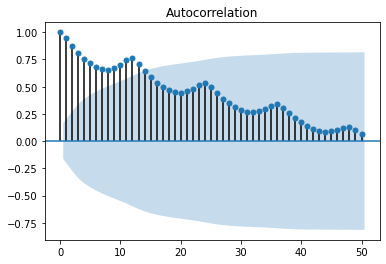

In [4]:
acf_val = acf(df.Pax,nlags=lag)
plot_acf(df.Pax,lags=lag)
acf_val

In [5]:
from scipy.stats import norm
import numpy                           as      np
import matplotlib.pyplot               as      plt

def get_confidence_interval(acf_val,n,ci=.95):
    ci1 = (1+ci)/2
    z_val = norm.ppf(ci1)/np.sqrt(n)
    arr =np.concatenate([np.array([1]), 2*acf_val[1:]**2])
    confidence_limit = z_val * np.sqrt(np.cumsum(arr))
    return(confidence_limit)

In [6]:
def get_acf_pacf_plot(acf_pacf_val,lag_series,upper_limit,lower_limit):
    plt.figure(figsize=(15,5))
    plt.fill_between(lag_series, upper_limit,color='#EBF5FB')
    plt.fill_between(lag_series, lower_limit,color='#EBF5FB')
    plt.plot(lag_series,[0]*len(lag_series),color='black')
    plt.bar(lag_series,acf_pacf_val,width=0.05,color='black')
    plt.scatter(lag_series,acf_pacf_val,color='black')
    plt.show()

In [7]:
def get_acf(y,lag=20,ci=.95,isplot=True):
    lag+=1
    mu = np.mean(y)
    var_s = np.var(y)
    n=len(y)
    acf_array = []
    lag_series = range(lag)
    for lag_n in lag_series:
        total=0
        for i in range(0,n-lag_n):
            total=total+(y[i]-mu)*(y[i+lag_n]-mu)
        auto_cov = total/n
        rk=auto_cov/var_s
        acf_array.append(rk)

    acf_array = np.array(acf_array)
    confidence_limit = get_confidence_interval(acf_array,n,ci)
    if isplot:
        get_acf_pacf_plot(acf_array,lag_series,confidence_limit,-1*confidence_limit)
    return(acf_array,confidence_limit,-1*confidence_limit)

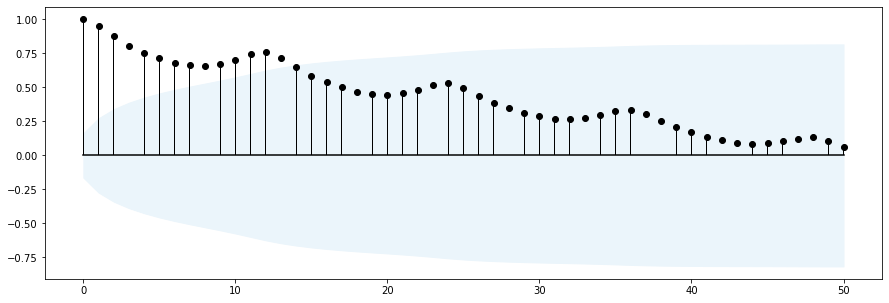

In [8]:
acf_manual,acf_upper_limit,acf_lower_limit = get_acf(df.Pax,lag=lag,ci=.95)

In [9]:
np.allclose(acf_manual,acf_val)

True

<Figure size 1080x360 with 0 Axes>

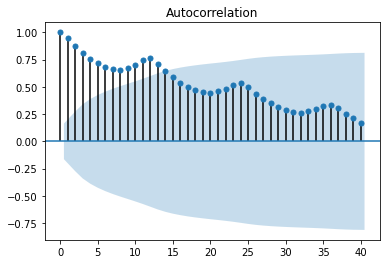

In [10]:
plt.figure(figsize=(15,5))
plot_acf(df.Pax,lags=40)
plt.show()

# PACF

array([ 1.        ,  0.95893198, -0.32983096,  0.2018249 ,  0.14500798,
        0.25848232, -0.02690283,  0.20433019,  0.15607896,  0.56860841,
        0.29256358,  0.8402143 ,  0.61268285, -0.66597616, -0.38463943,
        0.0787466 , -0.02663483, -0.05805221, -0.04350748,  0.27732556,
       -0.04046447,  0.13739883,  0.3859958 ,  0.24203808, -0.04912986,
       -0.19599778, -0.15443575,  0.04484465,  0.18371541, -0.0906113 ,
       -0.06202938,  0.34827092,  0.09899499, -0.08396793,  0.36328898,
       -0.17956662,  0.15839435,  0.06376775, -0.27503705,  0.2707607 ,
        0.32002003])

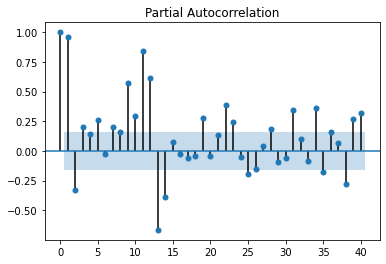

In [11]:
pacf_val = pacf(df.Pax, method='ols')
plot_pacf(df.Pax,lags=40,method='ols')
pacf_val

In [12]:
def get_pacf(series,lag,ci,isplot=True):
    n=len(series)
    lag+=1
    df_lag = pd.DataFrame()
    for i in range(1,lag+1):
        l = series.shift(periods=i)
        df_lag = pd.concat([df_lag,l],axis=1)

    df_lag.columns = ['lag_'+str(i) for i in range(1,lag+1)]
    
    features = df_lag.values
    labels = series.values
    pacf_manual = [1.]
    xlags = sm.add_constant(features)
    for k in range(1, lag):
        model = sm.OLS(labels[k:], xlags[k:, :k+1]).fit()
        pacf_manual.append(model.params[-1])
    pacf_manual = np.array(pacf_manual)
    confidence_limit = get_confidence_interval(pacf_manual,n,ci)
    
    if isplot:
        get_acf_pacf_plot(pacf_manual,range(lag),confidence_limit,-1*confidence_limit)
    return(pacf_manual,confidence_limit,-1*confidence_limit)

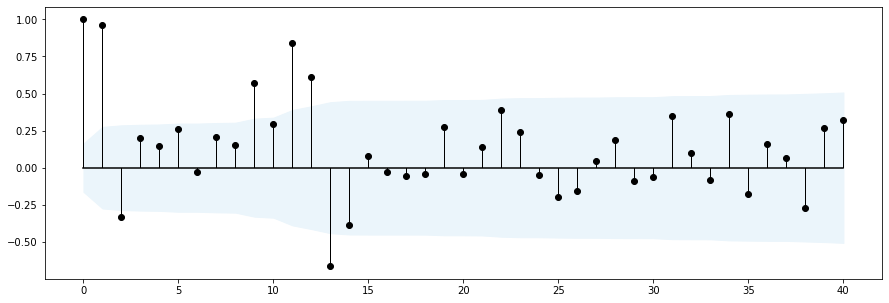

In [13]:
pacf_array,pacf_upper_limit,pacf_lower_limit = get_pacf(series=df.Pax,lag=40,ci=.95,isplot=True)